In [1]:
# Imports
import cv2 as cv
import os
import random
import tqdm
from vjutility import *

## Notebook test Viola-Jones pretrained model

In this notebook we use a pretrained Viola-Jones model to test the output on our dataset. The helper methods are defined in "vjutility.py"

### Helper methods for results :

In [2]:
# Helper methods to get the scores per comics (Usefull for data separation)

def get_nb_files_per_comics(folder) :
    """
    Compute the number of images per comics (Since the images are in subfolders of comics)
    
    : param : folder, the master folder containing all subfolders
    : return : lengths, a list containing the number of image per comics
    """
    
    lengths = []
    for subdir, dirs, files in os.walk(folder):
        if "checkpoints" not in files and "checkpoints" not in dirs and "checkpoints" not in subdir :
            lengths.append(len(files))
    return lengths[1:]


def compute_metric_per_comic(folder, groundtruth, pred, b_pred = False):
    """
    Compute the precision/recall/f-score for each comics
    
    : param : folder, the master folder containing all subfolders
    : groundtruth : The groundtruths of each images
    : pred : the outputs of the model
    : b_pred : depend on the form of the prediction (top left, width, heigth or top_left, bottom right)
    : return : the metrics for each comics
    """
    l = get_nb_files_per_comics(folder)
    results = []
    for i in range(len(l)):
        tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth[sum(l[:i]):sum(l[:i+1])], pred[sum(l[:i]):sum(l[:i+1])], b_pred)
        precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
        results.append((tp_tot, fp_tot, fn_tot, round(precision, 3), round(recall,3), round(f_score,3)))
    
    return results

def get_dict_comics(folder) :
    length = get_nb_files_per_comics(folder)
    sum_ = 0
    r = {}
    for i, l in enumerate(length):
        r[i] = ((sum_, l+sum_))
        sum_ += l
    return r


def print_exemple_comic(id_, dict_comics, nb = 100):
    for i in range(dict_comics[id_][0], min(dict_comics[id_][0] + nb, dict_comics[id_][1])):
        print_exemple(i)

### Prediction

Since the model is pretrained we test on every images

In [37]:
# Load the pretrained vj classifier and create a cascade object for face detection
face_cascade = cv.CascadeClassifier('../../opencv/sources/data/haarcascades/haarcascade_frontalface_default.xml')
#face_cascade = cv.CascadeClassifier('../../opencv/sources/data/haarcascades/haarcascade_frontalface_alt.xml')
#face_cascade = cv.CascadeClassifier('../../opencv/sources/data/haarcascades/haarcascade_frontalface_alt_tree.xml')

In [4]:
folder_img = "../dataset/images/images"
folder_gt = "../dataset/groundtruth"

print("Loading images from folder : ", folder_img)
images, path_images = load_images_from_folder(folder_img)
print("Check dataset length : ", len(images))

# Load groundtruth :
print("Loading groundtruth from folder : ", folder_gt)
groundtruth, path_groundtruth = load_face_groundtruth_from_folder(folder_gt, 5)
print("Check groundtruth length : ", len(groundtruth))

Loading images from folder :  ../dataset/images/images
Check dataset length :  772
Loading groundtruth from folder :  ../dataset/groundtruth
Check groundtruth length :  772


In [5]:
# Convert color image to grayscale for Viola-Jones
img_vj = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

In [38]:
pred_vj = []

# Get all the predictions
for img in tqdm.tqdm(img_vj) : 
    detected_faces = face_cascade.detectMultiScale(img)
    pred_vj.append(detected_faces)

100%|██████████| 772/772 [05:52<00:00,  2.19it/s]


### Results

In [63]:
def print_exemple(index, images, groundtruth, modified = False, pred = None, display = True) :
    '''
    Given an index, will print the image with the groundtruth and the prediction 

    :param image: given image
    :param int width: desired final width 
    :param int width: desired final height
    :Note : if both are given, height will be ignored to conserve aspect ratio
    :return: copy of the image resized
    ''' 
    copy = images[index].copy()
    
    if pred is not None:
        if pred[index] is not None:
            for (column, row, width, height) in pred[index]:
                cv.rectangle(copy, (column, row), (column + width, row + height),
                (0, 255, 0), 4)
    if modified :
        for (column, row, width, height) in groundtruth[index]:
            cv.rectangle(copy, (column, row), (column+width, row+height),
            (0, 0, 255), 4)
    else :
        if groundtruth[index].size > 0 :
            for (x1, y1, x2, y2) in groundtruth[index][:, 1:]:
                cv.rectangle(copy, (x1, y1), (x2, y2), (255, 0, 0), 4)

    copy = resize_img(copy, width=680)
    if display :
        cv.imshow("example", copy)
        cv.waitKey(0)  
        cv.destroyAllWindows()  
    return copy

In [30]:
sum_ = 0
for gt in groundtruth:
    sum_ += len(gt)
    
print("There is in total %s faces in the test set"%(sum_))

There is in total 5488 faces in the test set


#### Default

In [39]:
## default
dict_comics = get_dict_comics(folder_img)

results = compute_metric_per_comic(folder_img, groundtruth, pred_vj, True)
print("Id, tp, fp, fn , prec, recall, f_score")
for i, r in enumerate(results) :
    print(i, r)

Id, tp, fp, fn , prec, recall, f_score
0 (162, 89, 317, 0.645, 0.338, 0.437)
1 (27, 146, 374, 0.156, 0.067, 0.021)
2 (80, 339, 127, 0.191, 0.386, 0.148)
3 (23, 157, 130, 0.128, 0.15, 0.038)
4 (17, 118, 209, 0.126, 0.075, 0.019)
5 (120, 156, 151, 0.435, 0.443, 0.385)
6 (5, 79, 127, 0.06, 0.038, 0.005)
7 (4, 11, 19, 0.267, 0.174, 0.093)
8 (22, 132, 93, 0.143, 0.191, 0.055)
9 (21, 186, 131, 0.101, 0.138, 0.028)
10 (26, 177, 80, 0.128, 0.245, 0.063)
11 (2, 2, 13, 0.5, 0.133, 0.133)
12 (0, 1, 15, 0.0, 0.0, 0.0)
13 (4, 118, 181, 0.033, 0.022, 0.001)
14 (40, 77, 157, 0.342, 0.203, 0.139)
15 (68, 167, 227, 0.289, 0.231, 0.133)
16 (58, 146, 202, 0.284, 0.223, 0.127)
17 (37, 80, 199, 0.316, 0.157, 0.099)
18 (85, 227, 350, 0.272, 0.195, 0.106)
19 (52, 88, 178, 0.371, 0.226, 0.168)
20 (0, 34, 1, 0.0, 0.0, 0.0)
21 (144, 419, 216, 0.256, 0.4, 0.205)
22 (0, 3, 1, 0.0, 0.0, 0.0)
23 (14, 37, 100, 0.275, 0.123, 0.067)
24 (34, 49, 189, 0.41, 0.152, 0.125)
25 (45, 39, 284, 0.536, 0.137, 0.147)
26 (68, 63,

In [40]:
tp, fp, fn = compute_metrics(groundtruth, pred_vj, True)
prec, recall, f_score = prec_rec_f(tp, fp, fn)
print("tp, fp, fn , prec, recall, f_score")
print(tp, fp, fn, prec, recall, f_score)

tp, fp, fn , prec, recall, f_score
1158 3140 4330 0.2694276407631456 0.21100583090379008 0.1137016064153508


#### Alt

In [35]:
##alt
dict_comics = get_dict_comics(folder_img)

results = compute_metric_per_comic(folder_img, groundtruth, pred_vj, True)
print("Id, tp, fp, fn , prec, recall, f_score")
for i, r in enumerate(results) :
    print(i, r)

Id, tp, fp, fn , prec, recall, f_score
0 (89, 24, 390, 0.788, 0.186, 0.293)
1 (3, 13, 398, 0.188, 0.007, 0.003)
2 (45, 80, 162, 0.36, 0.217, 0.157)
3 (6, 36, 147, 0.143, 0.039, 0.011)
4 (15, 48, 211, 0.238, 0.066, 0.032)
5 (89, 69, 182, 0.563, 0.328, 0.37)
6 (4, 10, 128, 0.286, 0.03, 0.017)
7 (1, 2, 22, 0.333, 0.043, 0.029)
8 (14, 45, 101, 0.237, 0.122, 0.058)
9 (6, 34, 146, 0.15, 0.039, 0.012)
10 (11, 39, 95, 0.22, 0.104, 0.046)
11 (0, 2, 15, 0.0, 0.0, 0.0)
12 (0, 0, 15, 0.0, 0.0, 0.0)
13 (2, 20, 183, 0.091, 0.011, 0.002)
14 (16, 8, 181, 0.667, 0.081, 0.108)
15 (51, 38, 244, 0.573, 0.173, 0.198)
16 (36, 31, 224, 0.537, 0.138, 0.149)
17 (16, 30, 220, 0.348, 0.068, 0.047)
18 (44, 25, 391, 0.638, 0.101, 0.129)
19 (29, 24, 201, 0.547, 0.126, 0.138)
20 (0, 9, 1, 0.0, 0.0, 0.0)
21 (114, 119, 246, 0.489, 0.317, 0.31)
22 (0, 1, 1, 0.0, 0.0, 0.0)
23 (4, 6, 110, 0.4, 0.035, 0.028)
24 (31, 15, 192, 0.674, 0.139, 0.187)
25 (28, 3, 301, 0.903, 0.085, 0.154)
26 (52, 11, 275, 0.825, 0.159, 0.263)


In [36]:
tp, fp, fn = compute_metrics(groundtruth, pred_vj, True)
prec, recall, f_score = prec_rec_f(tp, fp, fn)
print("tp, fp, fn , prec, recall, f_score")
print(tp, fp, fn, prec, recall, f_score)

tp, fp, fn , prec, recall, f_score
706 742 4782 0.48756906077348067 0.12864431486880468 0.12544597554886203


#### Alt tree

In [31]:
##alt_tree

dict_comics = get_dict_comics(folder_img)

results = compute_metric_per_comic(folder_img, groundtruth, pred_vj, True)
print("Id, tp, fp, fn , prec, recall, f_score")
for i, r in enumerate(results) :
    print(i, r)

Id, tp, fp, fn , prec, recall, f_score
0 (12, 0, 467, 1.0, 0.025, 0.049)
1 (1, 0, 400, 1.0, 0.002, 0.005)
2 (5, 1, 202, 0.833, 0.024, 0.04)
3 (0, 1, 153, 0.0, 0.0, 0.0)
4 (0, 0, 226, 0.0, 0.0, 0.0)
5 (13, 2, 258, 0.867, 0.048, 0.083)
6 (1, 0, 131, 1.0, 0.008, 0.015)
7 (0, 0, 23, 0.0, 0.0, 0.0)
8 (3, 0, 112, 1.0, 0.026, 0.051)
9 (0, 2, 152, 0.0, 0.0, 0.0)
10 (1, 0, 105, 1.0, 0.009, 0.019)
11 (0, 0, 15, 0.0, 0.0, 0.0)
12 (0, 0, 15, 0.0, 0.0, 0.0)
13 (0, 1, 185, 0.0, 0.0, 0.0)
14 (3, 0, 194, 1.0, 0.015, 0.03)
15 (11, 0, 284, 1.0, 0.037, 0.072)
16 (5, 1, 255, 0.833, 0.019, 0.032)
17 (1, 0, 235, 1.0, 0.004, 0.008)
18 (6, 0, 429, 1.0, 0.014, 0.027)
19 (1, 0, 229, 1.0, 0.004, 0.009)
20 (0, 0, 1, 0.0, 0.0, 0.0)
21 (21, 1, 339, 0.955, 0.058, 0.11)
22 (0, 0, 1, 0.0, 0.0, 0.0)
23 (0, 0, 114, 0.0, 0.0, 0.0)
24 (0, 0, 223, 0.0, 0.0, 0.0)
25 (0, 0, 329, 0.0, 0.0, 0.0)
26 (6, 0, 321, 1.0, 0.018, 0.036)


In [32]:
tp, fp, fn = compute_metrics(groundtruth, pred_vj, True)
prec, recall, f_score = prec_rec_f(tp, fp, fn)
print("tp, fp, fn , prec, recall, f_score")
print(tp, fp, fn, prec, recall, f_score)

tp, fp, fn , prec, recall, f_score
90 9 5398 0.9090909090909091 0.01639941690962099 0.029817121653856343


## Print some images

Using the default pretrained model (haarcascade_frontalface_default.xml)

- BLUE SQUARES : Groundtruths
- GREEN SQUARES : Predictions

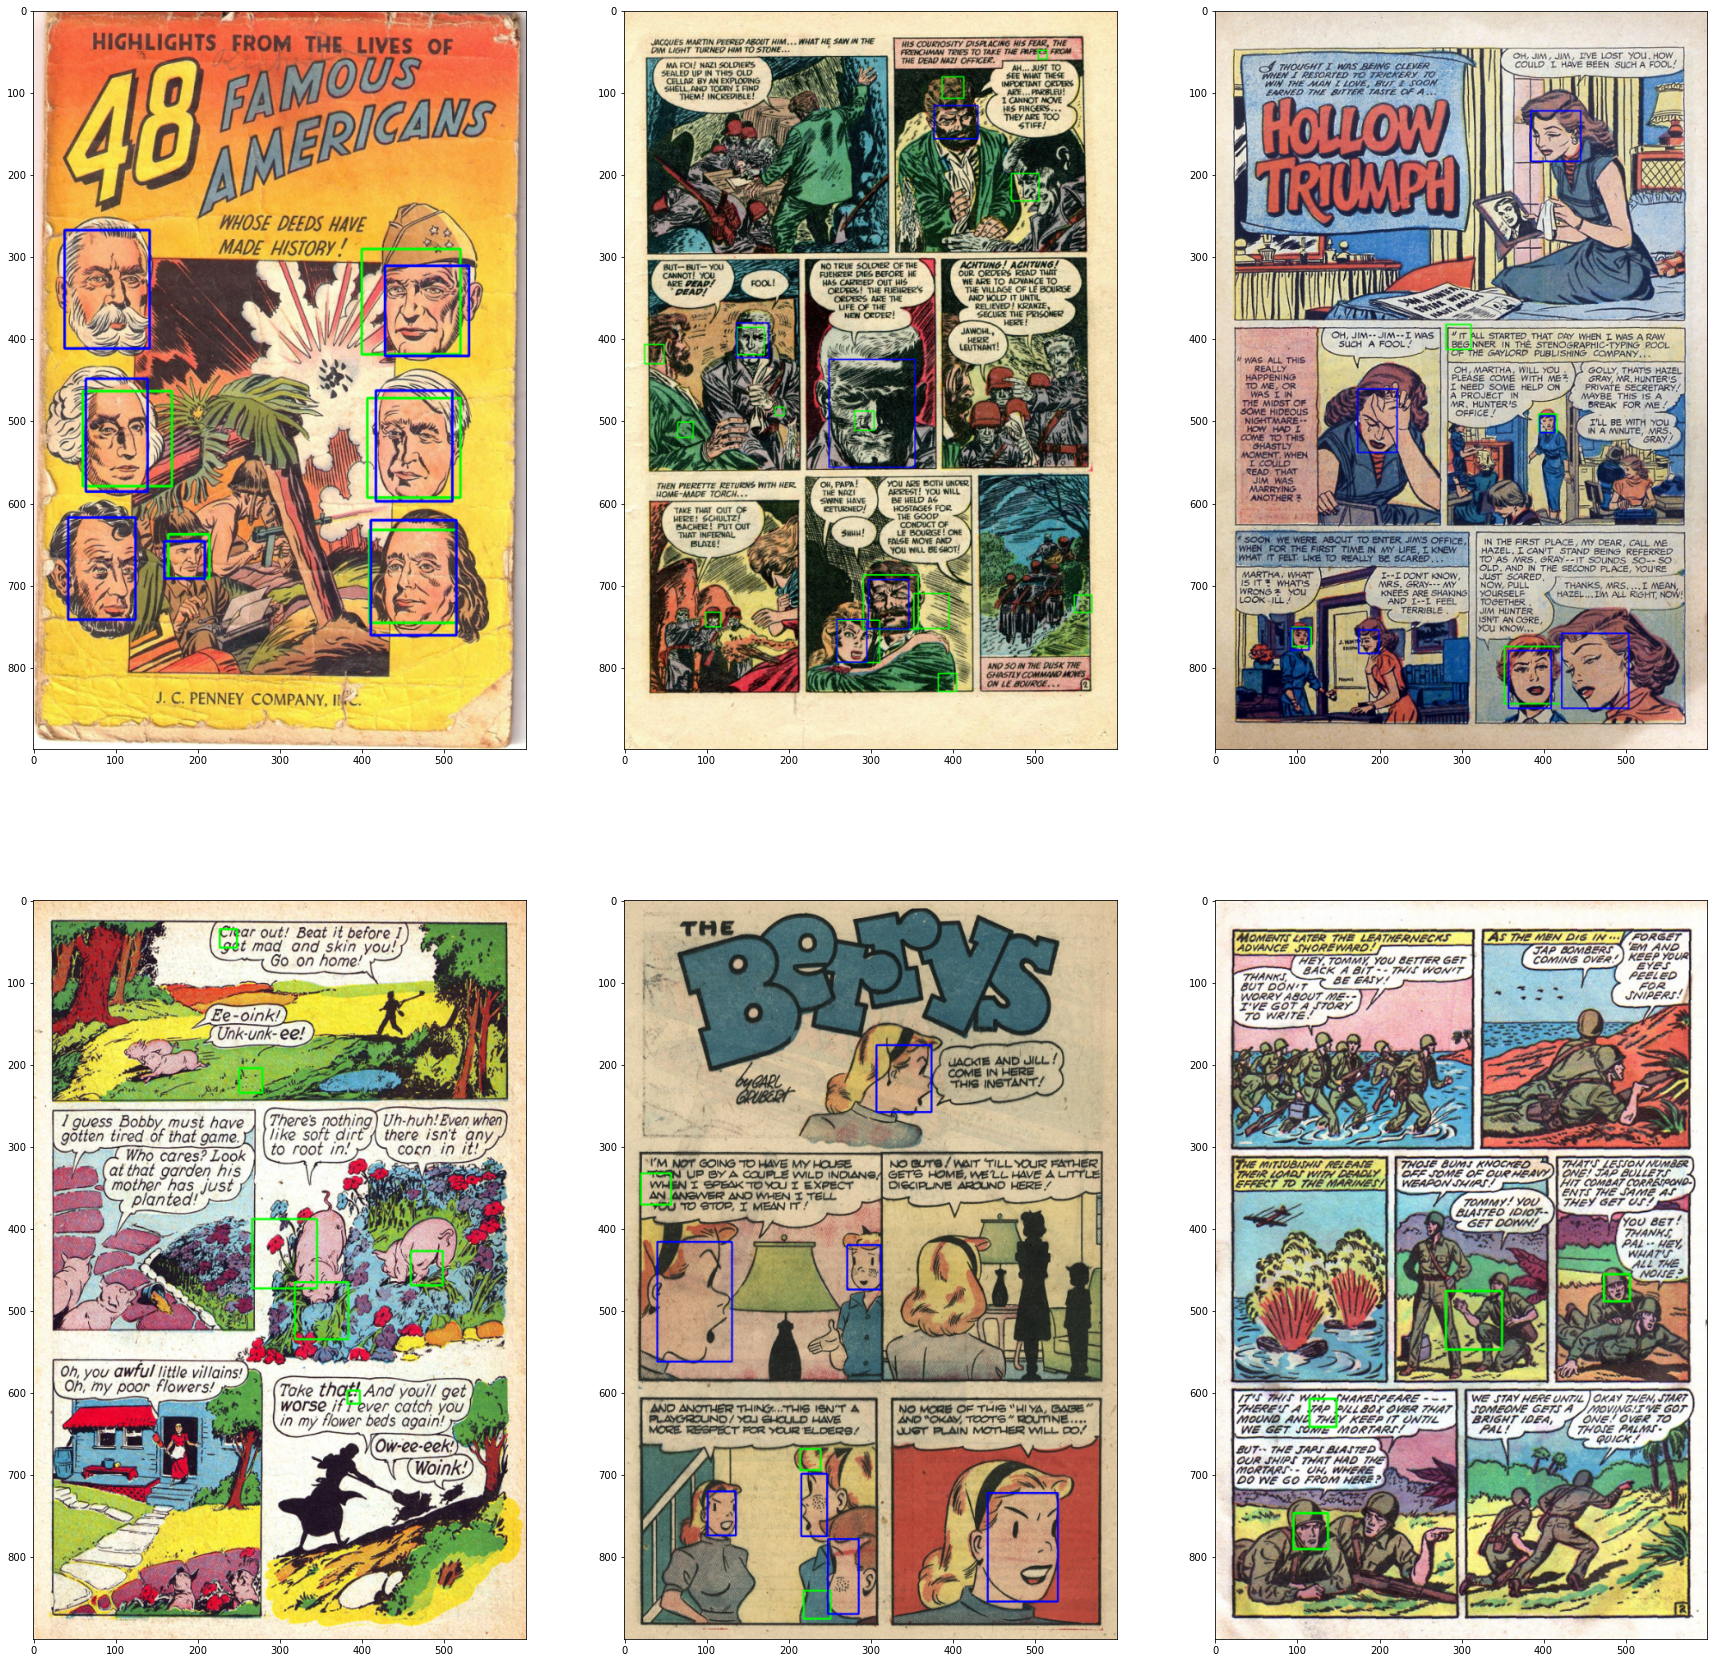

In [64]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


fig=plt.figure(figsize=(30, 30))
columns = 3
rows = 2

exemples = [0, 100, 200, 300, 400, 500]
for i in range(1, columns*rows + 1):
    r = print_exemple(exemples[i-1], images, groundtruth, pred = pred_vj, display = False) 
    img = cv.resize(r, (600, 900), interpolation=cv.INTER_LINEAR)
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()